![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

# 4. Named Entity Recognition (NER) DL Training

## Blogposts and videos:

https://towardsdatascience.com/named-entity-recognition-ner-with-bert-in-spark-nlp-874df20d1d77

NerDL worksghop (90 min): https://www.youtube.com/watch?v=YM-e4eOiQ34

https://medium.com/spark-nlp/named-entity-recognition-for-healthcare-with-sparknlp-nerdl-and-nercrf-a7751b6ad571

https://medium.com/atlas-research/ner-for-clinical-text-7c73caddd180

## Start Spark Session

In [2]:
import json
import os


import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline,PipelineModel

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

print("Spark NLP Version :", sparknlp.version())

spark = sparknlp.start()
# params =>> gpu=False
spark.sparkContext.setLogLevel("ERROR")

spark

Spark NLP Version : 4.2.4
Spark Session already created, some configs may not take.


## CoNLL Data Prep 

In [2]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/src/test/resources/conll2003/eng.train
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/src/test/resources/conll2003/eng.testa

In [3]:
with open("eng.train") as f:
    train_txt =f.read()

print (train_txt[:500])

-DOCSTART- -X- -X- O

EU NNP B-NP B-ORG
rejects VBZ B-VP O
German JJ B-NP B-MISC
call NN I-NP O
to TO B-VP O
boycott VB I-VP O
British JJ B-NP B-MISC
lamb NN I-NP O
. . O O

Peter NNP B-NP B-PER
Blackburn NNP I-NP I-PER

BRUSSELS NNP B-NP B-LOC
1996-08-22 CD I-NP O

The DT B-NP O
European NNP I-NP B-ORG
Commission NNP I-NP I-ORG
said VBD B-VP O
on IN B-PP O
Thursday NNP B-NP O
it PRP B-NP O
disagreed VBD B-VP O
with IN B-PP O
German JJ B-NP B-MISC
advice NN I-NP O
to TO B-PP O
consumers NNS B-NP


In [4]:
from sparknlp.training import CoNLL

training_data = CoNLL().readDataset(spark, './eng.train')

training_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|EU rejects German...|[{document, 0, 47...|[{document, 0, 47...|[{token, 0, 1, EU...|[{pos, 0, 1, NNP,...|[{named_entity, 0...|
|     Peter Blackburn|[{document, 0, 14...|[{document, 0, 14...|[{token, 0, 4, Pe...|[{pos, 0, 4, NNP,...|[{named_entity, 0...|
| BRUSSELS 1996-08-22|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 7, BR...|[{pos, 0, 7, NNP,...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [5]:
training_data.printSchema()

root
 |-- text: string (nullable = true)
 |-- document: array (nullable = false)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- sentence: array (nullable = false)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = tr

In [6]:
training_data.cache()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|EU rejects German...|[{document, 0, 47...|[{document, 0, 47...|[{token, 0, 1, EU...|[{pos, 0, 1, NNP,...|[{named_entity, 0...|
|     Peter Blackburn|[{document, 0, 14...|[{document, 0, 14...|[{token, 0, 4, Pe...|[{pos, 0, 4, NNP,...|[{named_entity, 0...|
| BRUSSELS 1996-08-22|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 7, BR...|[{pos, 0, 7, NNP,...|[{named_entity, 0...|
|The European Comm...|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 2, Th...|[{pos, 0, 2, DT, ...|[{named_entity, 0...|
|Germany 's repres...|[{document, 0, 21...|[{document, 0, 21...|[{token, 0, 6, Ge...|[{pos, 0, 6, NNP,...|[{named_entity, 0...|
|" We do n't suppo...|[{document, 0, 16...|[{document, 0, 16...|[{token, 0, 0, ",...|[{pos, 0, 0, ", {...|[{named_entity, 0...|
|He said further s...|[{document, 0, 13...|[{document, 0, 13...|[{token, 0, 1, He...|[{pos, 0, 1, PRP,...|[{named_entity, 0...|
|He said a proposa...|[{document, 0, 22...|[{document, 0, 22...|[{token, 0, 1, He...|[{pos, 0, 1, PRP,...|[{named_entity, 0...|
|Fischler proposed...|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 7, Fi...|[{pos, 0, 7, JJR,...|[{named_entity, 0...|
|But Fischler agre...|[{document, 0, 21...|[{document, 0, 21...|[{token, 0, 2, Bu...|[{pos, 0, 2, CC, ...|[{named_entity, 0...|
|Spanish Farm Mini...|[{document, 0, 16...|[{document, 0, 16...|[{token, 0, 6, Sp...|[{pos, 0, 6, NNP,...|[{named_entity, 0...|
|                   .|[{document, 0, 0,...|[{document, 0, 0,...|[{token, 0, 0, .,...|[{pos, 0, 0, ., {...|[{named_entity, 0...|
|Only France and B...|[{document, 0, 52...|[{document, 0, 52...|[{token, 0, 3, On...|[{pos, 0, 3, RB, ...|[{named_entity, 0...|
|The EU 's scienti...|[{document, 0, 17...|[{document, 0, 17...|[{token, 0, 2, Th...|[{pos, 0, 2, DT, ...|[{named_entity, 0...|
|Sheep have long b...|[{document, 0, 17...|[{document, 0, 17...|[{token, 0, 4, Sh...|[{pos, 0, 4, NNP,...|[{named_entity, 0...|
|British farmers d...|[{document, 0, 21...|[{document, 0, 21...|[{token, 0, 6, Br...|[{pos, 0, 6, JJ, ...|[{named_entity, 0...|
|" What we have to...|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 0, ",...|[{pos, 0, 0, ", {...|[{named_entity, 0...|
|Bonn has led effo...|[{document, 0, 21...|[{document, 0, 21...|[{token, 0, 3, Bo...|[{pos, 0, 3, NNP,...|[{named_entity, 0...|
|Germany imported ...|[{document, 0, 84...|[{document, 0, 84...|[{token, 0, 6, Ge...|[{pos, 0, 6, NNP,...|[{named_entity, 0...|
|It brought in 4,2...|[{document, 0, 82...|[{document, 0, 82...|[{token, 0, 1, It...|[{pos, 0, 1, PRP,...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 20 rows

In [7]:
%time training_data.count()

CPU times: user 2.59 ms, sys: 1.28 ms, total: 3.86 ms
Wall time: 1.41 s


14041

In [8]:
%time training_data.count()

CPU times: user 1.32 ms, sys: 653 Âµs, total: 1.97 ms
Wall time: 353 ms


14041

In [9]:
import pyspark.sql.functions as F

training_data.select(F.explode(F.arrays_zip(training_data.token.result, 
                                            training_data.pos.result, 
                                            training_data.label.result)).alias("cols")) \
             .select(F.expr("cols['0']").alias("token"),
                     F.expr("cols['1']").alias("pos"),
                     F.expr("cols['2']").alias("ner_label")).show(truncate=50)

+----------+---+---------+
|     token|pos|ner_label|
+----------+---+---------+
|        EU|NNP|    B-ORG|
|   rejects|VBZ|        O|
|    German| JJ|   B-MISC|
|      call| NN|        O|
|        to| TO|        O|
|   boycott| VB|        O|
|   British| JJ|   B-MISC|
|      lamb| NN|        O|
|         .|  .|        O|
|     Peter|NNP|    B-PER|
| Blackburn|NNP|    I-PER|
|  BRUSSELS|NNP|    B-LOC|
|1996-08-22| CD|        O|
|       The| DT|        O|
|  European|NNP|    B-ORG|
|Commission|NNP|    I-ORG|
|      said|VBD|        O|
|        on| IN|        O|
|  Thursday|NNP|        O|
|        it|PRP|        O|
+----------+---+---------+
only showing top 20 rows



In [10]:
training_data.select(F.explode(F.arrays_zip(training_data.token.result,
                                            training_data.label.result)).alias("cols")) \
             .select(F.expr("cols['0']").alias("token"),
                     F.expr("cols['1']").alias("ground_truth")).groupBy('ground_truth').count().orderBy('count', ascending=False).show(100,truncate=False)

+------------+------+
|ground_truth|count |
+------------+------+
|O           |169578|
|B-LOC       |7140  |
|B-PER       |6600  |
|B-ORG       |6321  |
|I-PER       |4528  |
|I-ORG       |3704  |
|B-MISC      |3438  |
|I-LOC       |1157  |
|I-MISC      |1155  |
+------------+------+



In [11]:
# You can use any word embeddings you want (Glove, Elmo, Bert, custom etc.)

glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d')\
          .setInputCols(["document", "token"])\
          .setOutputCol("embeddings")
    

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ | ]glove_100d download started this may take some time.
Approximate size to download 145.3 MB
Download done! Loading the resource.
[OK!]


In [12]:
!mkdir ner_logs

mkdir: cannot create directory â€˜ner_logsâ€™: File exists


In [13]:
nerTagger = NerDLApproach()\
      .setInputCols(["sentence", "token", "embeddings"])\
      .setLabelColumn("label")\
      .setOutputCol("ner")\
      .setMaxEpochs(1)\
      .setLr(0.003)\
      .setBatchSize(32)\
      .setRandomSeed(0)\
      .setVerbose(1)\
      .setValidationSplit(0.2)\
      .setEvaluationLogExtended(True) \
      .setEnableOutputLogs(True)\
      .setIncludeConfidence(True)\
      .setOutputLogsPath('/home/ubuntu/ner_logs') # if not set, logs will be written to ~/annotator_logs
 #    .setGraphFolder('graphs') >> put your graph file (pb) under this folder if you are using a custom graph generated thru 4.1 NerDL-Graph.ipynb notebook
 #    .setEnableMemoryOptimizer() >> if you have a limited memory and a large conll file, you can set this True to train batch by batch 
    
ner_pipeline = Pipeline(stages=[
      glove_embeddings,
      nerTagger
 ])


### Fitting

In [14]:
%%time

ner_model = ner_pipeline.fit(training_data)

# 1 epoch takes around 3 min with batch size=32
# if you get an error for incompatible TF graph, use 4.1 NerDL-Graph.ipynb notebook to create a graph (or see the bottom cell of this notebook)

Training started - total epochs: 1 - lr: 0.003 - batch size: 32 - labels: 9 - chars: 84 - training examples: 11194
Epoch 1/1 started, lr: 0.003, dataset size: 11194
Epoch 1/1 - 36.46s - loss: 955.0922 - batches: 352
Quality on validation dataset (20.0%), validation examples = 2238
time to finish evaluation: 2.95s
label	 tp	 fp	 fn	 prec	 rec	 f1
B-LOC	 1369	 150	 91	 0.90125084	 0.93767124	 0.9191004
I-ORG	 585	 115	 145	 0.8357143	 0.80136985	 0.8181818
I-MISC	 171	 36	 116	 0.82608694	 0.5958188	 0.6923077
I-LOC	 207	 58	 56	 0.7811321	 0.78707224	 0.7840909
I-PER	 878	 37	 23	 0.95956284	 0.9744728	 0.9669604
B-MISC	 597	 76	 138	 0.8870728	 0.8122449	 0.8480114
B-ORG	 1105	 206	 162	 0.84286803	 0.8721389	 0.8572537
B-PER	 1268	 74	 75	 0.94485843	 0.94415486	 0.9445065
tp: 6180 fp: 752 fn: 806 labels: 8
Macro-average	 prec: 0.87231827, rec: 0.84061795, f1: 0.85617477
Micro-average	 prec: 0.8915176, rec: 0.8846264, f1: 0.8880586
CPU times: user 175 ms, sys: 20.3 ms, total: 196 ms
W

In [15]:
import os

log_files = os.listdir("/home/ubuntu/ner_logs")
log_files

['NerDLApproach_129f372f52f4.log']

In [16]:
with open("/home/ubuntu/ner_logs/"+log_files[0]) as log_file:
    print(log_file.read())

Name of the selected graph: ner-dl/blstm_10_100_128_120.pb
Training started - total epochs: 1 - lr: 0.003 - batch size: 32 - labels: 9 - chars: 84 - training examples: 11194


Epoch 1/1 started, lr: 0.003, dataset size: 11194


Epoch 1/1 - 36.46s - loss: 955.0922 - batches: 352
Quality on validation dataset (20.0%), validation examples = 2238
time to finish evaluation: 2.95s
label	 tp	 fp	 fn	 prec	 rec	 f1
B-LOC	 1369	 150	 91	 0.90125084	 0.93767124	 0.9191004
I-ORG	 585	 115	 145	 0.8357143	 0.80136985	 0.8181818
I-MISC	 171	 36	 116	 0.82608694	 0.5958188	 0.6923077
I-LOC	 207	 58	 56	 0.7811321	 0.78707224	 0.7840909
I-PER	 878	 37	 23	 0.95956284	 0.9744728	 0.9669604
B-MISC	 597	 76	 138	 0.8870728	 0.8122449	 0.8480114
B-ORG	 1105	 206	 162	 0.84286803	 0.8721389	 0.8572537
B-PER	 1268	 74	 75	 0.94485843	 0.94415486	 0.9445065
tp: 6180 fp: 752 fn: 806 labels: 8
Macro-average	 prec: 0.87231827, rec: 0.84061795, f1: 0.85617477
Micro-average	 prec: 0.8915176, rec: 0.8846264, f1: 

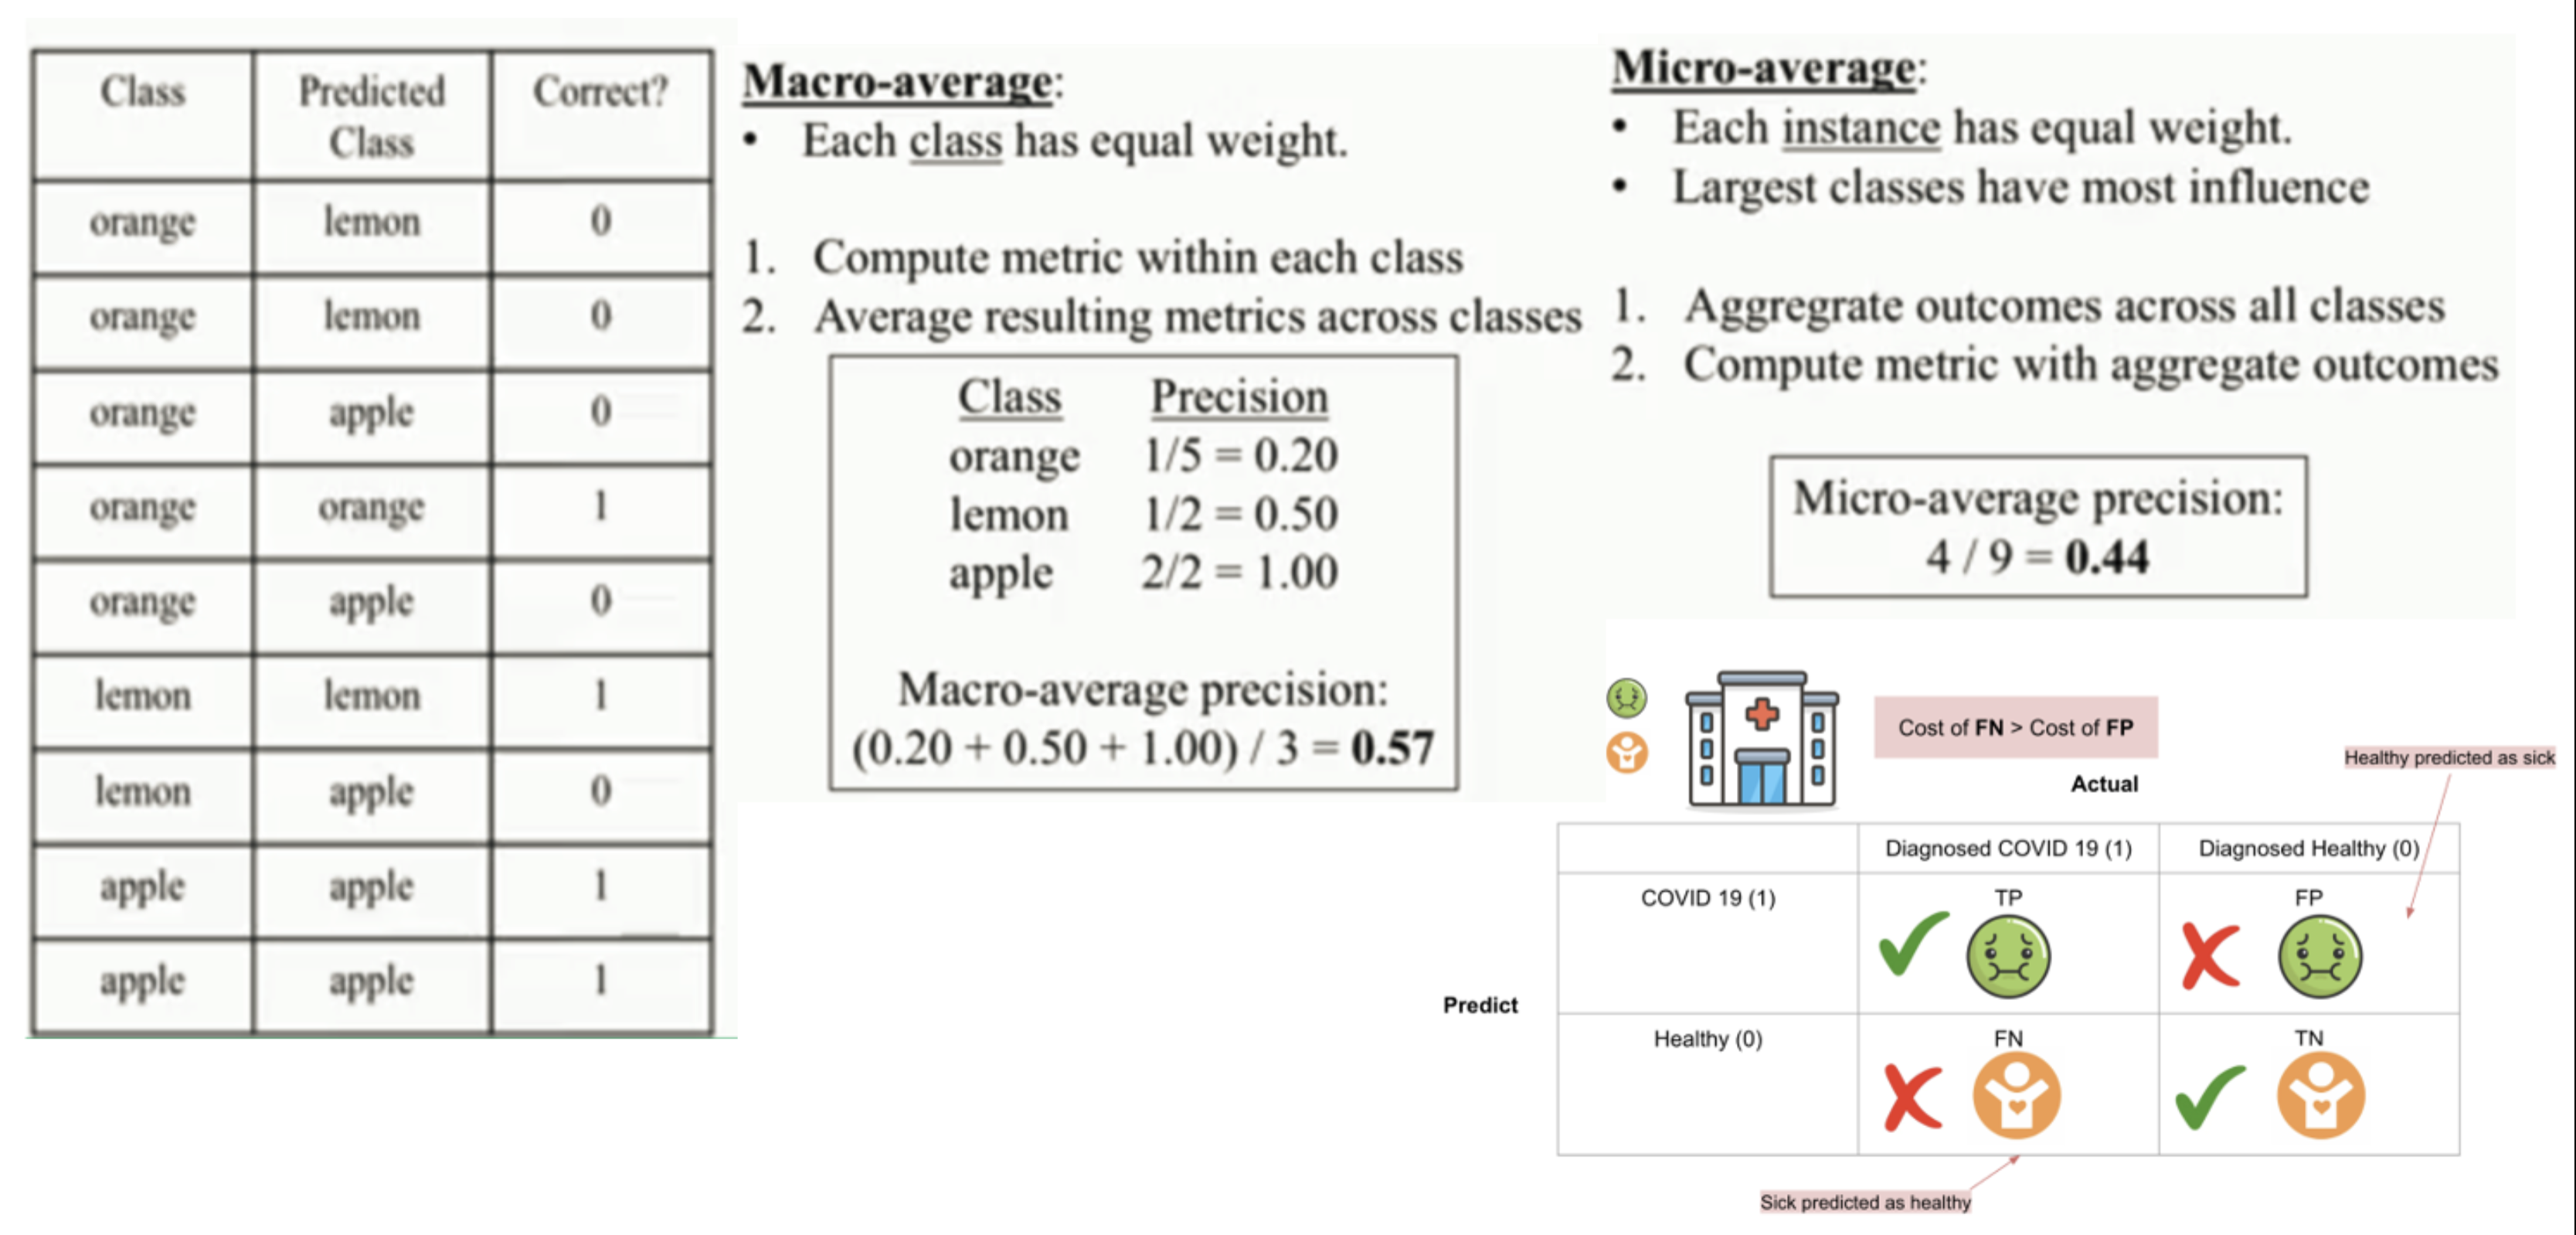

In [17]:
from sparknlp.training import CoNLL

test_data = CoNLL().readDataset(spark, './eng.testa')

test_data = glove_embeddings.transform(test_data)

test_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|          embeddings|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|CRICKET - LEICEST...|[{document, 0, 64...|[{document, 0, 64...|[{token, 0, 6, CR...|[{pos, 0, 6, NNP,...|[{named_entity, 0...|[{word_embeddings...|
|   LONDON 1996-08-30|[{document, 0, 16...|[{document, 0, 16...|[{token, 0, 5, LO...|[{pos, 0, 5, NNP,...|[{named_entity, 0...|[{word_embeddings...|
|West Indian all-r...|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 3, We...|[{pos, 0, 3, NNP,...|[{named_entity, 0...|[{word_embeddings...|
+--------------------+--------------------+--------------------+--------------------+--------------------+

In [18]:
predictions = ner_model.transform(test_data)
predictions.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|          embeddings|                 ner|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|CRICKET - LEICEST...|[{document, 0, 64...|[{document, 0, 64...|[{token, 0, 6, CR...|[{pos, 0, 6, NNP,...|[{named_entity, 0...|[{word_embeddings...|[{named_entity, 0...|
|   LONDON 1996-08-30|[{document, 0, 16...|[{document, 0, 16...|[{token, 0, 5, LO...|[{pos, 0, 5, NNP,...|[{named_entity, 0...|[{word_embeddings...|[{named_entity, 0...|
|West Indian all-r...|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 3, We...|[{pos, 0, 3, NNP,...|[{named_entity, 0...|[{word_embeddings...|[{

In [19]:
predictions.select('token.result','label.result','ner.result').show(3, truncate=50)

+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|                                            result|                                            result|                                            result|
+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|[CRICKET, -, LEICESTERSHIRE, TAKE, OVER, AT, TO...|             [O, O, B-ORG, O, O, O, O, O, O, O, O]|             [O, O, B-ORG, O, O, O, O, O, O, O, O]|
|                              [LONDON, 1996-08-30]|                                        [B-LOC, O]|                                        [B-LOC, O]|
|[West, Indian, all-rounder, Phil, Simmons, took...|[B-MISC, I-MISC, O, B-PER, I-PER, O, O, O, O, O...|[B-MISC, I-MISC, O, B-PER, I-PER, O, O, O, O, O...|
+--------------------------------------------------+------------------

### Test set evaluation

In [20]:
import pyspark.sql.functions as F

predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                          predictions.label.result,
                                          predictions.ner.result)).alias("cols")) \
                              .select(F.expr("cols['0']").alias("token"),
                                      F.expr("cols['1']").alias("ground_truth"),
                                      F.expr("cols['2']").alias("prediction")).show(truncate=False)

+--------------+------------+----------+
|token         |ground_truth|prediction|
+--------------+------------+----------+
|CRICKET       |O           |O         |
|-             |O           |O         |
|LEICESTERSHIRE|B-ORG       |B-ORG     |
|TAKE          |O           |O         |
|OVER          |O           |O         |
|AT            |O           |O         |
|TOP           |O           |O         |
|AFTER         |O           |O         |
|INNINGS       |O           |O         |
|VICTORY       |O           |O         |
|.             |O           |O         |
|LONDON        |B-LOC       |B-LOC     |
|1996-08-30    |O           |O         |
|West          |B-MISC      |B-MISC    |
|Indian        |I-MISC      |I-MISC    |
|all-rounder   |O           |O         |
|Phil          |B-PER       |B-PER     |
|Simmons       |I-PER       |I-PER     |
|took          |O           |O         |
|four          |O           |O         |
+--------------+------------+----------+
only showing top

Licensed user will have an access to internal NERDLMetrics module to do this more efficient and easily without going out of Spark. But open source users need to use sklearn.metrics or any other equivalent module to do the same.

In [21]:
from sklearn.metrics import classification_report

preds_df = predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                                     predictions.label.result,
                                                     predictions.ner.result)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(preds_df['ground_truth'], preds_df['prediction']))


              precision    recall  f1-score   support

       B-LOC       0.89      0.94      0.92      1837
      B-MISC       0.87      0.82      0.85       922
       B-ORG       0.85      0.85      0.85      1341
       B-PER       0.96      0.96      0.96      1842
       I-LOC       0.79      0.76      0.77       257
      I-MISC       0.80      0.61      0.69       346
       I-ORG       0.84      0.71      0.77       751
       I-PER       0.97      0.97      0.97      1307
           O       0.99      1.00      0.99     42759

    accuracy                           0.98     51362
   macro avg       0.89      0.85      0.86     51362
weighted avg       0.98      0.98      0.98     51362



### Entity level evaluation (strict eval)

In [22]:
!wget  -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/conll_eval.py

In [23]:
import conll_eval

metrics = conll_eval.evaluate(preds_df['ground_truth'].values, preds_df['prediction'].values)

processed 51362 tokens with 5942 phrases; found: 6064 phrases; correct: 5280.
accuracy:  88.45%; (non-O)
accuracy:  97.79%; precision:  87.07%; recall:  88.86%; FB1:  87.96
              LOC: precision:  88.44%; recall:  93.74%; FB1:  91.01  1947
             MISC: precision:  80.53%; recall:  78.52%; FB1:  79.52  899
              ORG: precision:  79.88%; recall:  80.84%; FB1:  80.36  1357
              PER: precision:  94.04%; recall:  95.01%; FB1:  94.52  1861


In [24]:
# micro, macro, avg
metrics[0]

(87.0712401055409, 88.85897004375632, 87.95602198900549)

In [25]:
import pandas as pd
pd.DataFrame(metrics[1], columns=['entity','precision','recall','f1','support'])

entity  precision     recall         f1  support
0    LOC  88.443760  93.739793  91.014799     1947
1   MISC  80.533927  78.524946  79.516749      899
2    ORG  79.882093  80.835198  80.355819     1357
3    PER  94.035465  95.005429  94.517958     1861

### Splitting Dataset Into Train and Test Set

Also we will use `.setTestDataset('ner_dl_test.parquet')` for checking test-loss values of each epoch in the logs file and `.useBestModel(True)` parameter whether to restore and use the model that has achieved the best performance at the end of the training. . 



In [26]:
from sparknlp.training import CoNLL

conll_data = CoNLL().readDataset(spark, './eng.train')

(training_data, test_data) = conll_data.randomSplit([0.7, 0.3], seed = 100)

print("Training Dataset Count: " + str(training_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 9739
Test Dataset Count: 4302


In [27]:
!mkdir ner_logs_best

mkdir: cannot create directory â€˜ner_logs_bestâ€™: File exists


In [29]:
glove_embeddings.transform(test_data).write.parquet('ner_dl_test.parquet')

In [30]:
%%time
nerTagger = NerDLApproach()\
      .setInputCols(["sentence", "token", "embeddings"])\
      .setLabelColumn("label")\
      .setOutputCol("ner")\
      .setMaxEpochs(5)\
      .setLr(0.003)\
      .setBatchSize(32)\
      .setRandomSeed(0)\
      .setVerbose(1)\
      .setValidationSplit(0.2)\
      .setEvaluationLogExtended(True) \
      .setEnableOutputLogs(True)\
      .setIncludeConfidence(True)\
      .setUseBestModel(True)\
      .setTestDataset('ner_dl_test.parquet')\
      .setOutputLogsPath('/home/ubuntu/ner_logs_best') # if not set, logs will be written to ~/annotator_logs

ner_pipeline = Pipeline(stages=[
      glove_embeddings,
      nerTagger
 ])


ner_model = ner_pipeline.fit(training_data)

Training started - total epochs: 5 - lr: 0.003 - batch size: 32 - labels: 9 - chars: 84 - training examples: 7700
Epoch 1/5 started, lr: 0.003, dataset size: 7700
Epoch 1/5 - 25.36s - loss: 982.52936 - batches: 243
Quality on validation dataset (20.0%), validation examples = 1540
time to finish evaluation: 2.22s
label	 tp	 fp	 fn	 prec	 rec	 f1
B-LOC	 981	 245	 53	 0.80016315	 0.94874275	 0.8681416
I-ORG	 357	 38	 189	 0.90379745	 0.65384614	 0.7587672
I-MISC	 84	 57	 54	 0.59574467	 0.6086956	 0.6021505
I-LOC	 121	 71	 28	 0.6302083	 0.81208056	 0.7096774
I-PER	 605	 23	 34	 0.9633758	 0.9467919	 0.95501184
B-MISC	 371	 73	 97	 0.8355856	 0.79273504	 0.8135965
B-ORG	 731	 107	 227	 0.87231505	 0.763048	 0.8140311
B-PER	 926	 59	 67	 0.9401015	 0.9325277	 0.9362993
tp: 4176 fp: 673 fn: 749 labels: 8
Macro-average	 prec: 0.81766146, rec: 0.8073085, f1: 0.812452
Micro-average	 prec: 0.8612085, rec: 0.8479188, f1: 0.854512
Quality on test dataset: 
time to finish evaluation: 3.91s
label	 

In [31]:
log_files = os.listdir("/home/ubuntu/ner_logs_best/")
log_files

['NerDLApproach_064a80fb5df0.log']

In [32]:
with open("/home/ubuntu/ner_logs_best/"+log_files[0]) as log_file:
    print(log_file.read())

Name of the selected graph: ner-dl/blstm_10_100_128_120.pb
Training started - total epochs: 5 - lr: 0.003 - batch size: 32 - labels: 9 - chars: 84 - training examples: 7700


Epoch 1/5 started, lr: 0.003, dataset size: 7700


Epoch 1/5 - 25.36s - loss: 982.52936 - batches: 243
Quality on validation dataset (20.0%), validation examples = 1540
time to finish evaluation: 2.22s
label	 tp	 fp	 fn	 prec	 rec	 f1
B-LOC	 981	 245	 53	 0.80016315	 0.94874275	 0.8681416
I-ORG	 357	 38	 189	 0.90379745	 0.65384614	 0.7587672
I-MISC	 84	 57	 54	 0.59574467	 0.6086956	 0.6021505
I-LOC	 121	 71	 28	 0.6302083	 0.81208056	 0.7096774
I-PER	 605	 23	 34	 0.9633758	 0.9467919	 0.95501184
B-MISC	 371	 73	 97	 0.8355856	 0.79273504	 0.8135965
B-ORG	 731	 107	 227	 0.87231505	 0.763048	 0.8140311
B-PER	 926	 59	 67	 0.9401015	 0.9325277	 0.9362993
tp: 4176 fp: 673 fn: 749 labels: 8
Macro-average	 prec: 0.81766146, rec: 0.8073085, f1: 0.812452
Micro-average	 prec: 0.8612085, rec: 0.8479188, f1: 0.854512
Qua

In [33]:
test_data = glove_embeddings.transform(test_data)

predictions = ner_model.transform(test_data)

from sklearn.metrics import classification_report

preds_df = predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                                     predictions.label.result,
                                                     predictions.ner.result)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(preds_df['ground_truth'], preds_df['prediction'], digits=4))


              precision    recall  f1-score   support

       B-LOC     0.9371    0.9518    0.9444      2159
      B-MISC     0.9177    0.8949    0.9062      1047
       B-ORG     0.8898    0.9185    0.9039      1926
       B-PER     0.9709    0.9643    0.9676      2042
       I-LOC     0.8758    0.8281    0.8513       349
      I-MISC     0.8427    0.7916    0.8163       379
       I-ORG     0.9043    0.8649    0.8841      1147
       I-PER     0.9820    0.9834    0.9827      1446
           O     0.9959    0.9965    0.9962     52122

    accuracy                         0.9849     62617
   macro avg     0.9240    0.9104    0.9170     62617
weighted avg     0.9849    0.9849    0.9849     62617



### Ner log parser

In [34]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/ner_log_parser.py

In [35]:
import ner_log_parser

In [36]:
%matplotlib inline

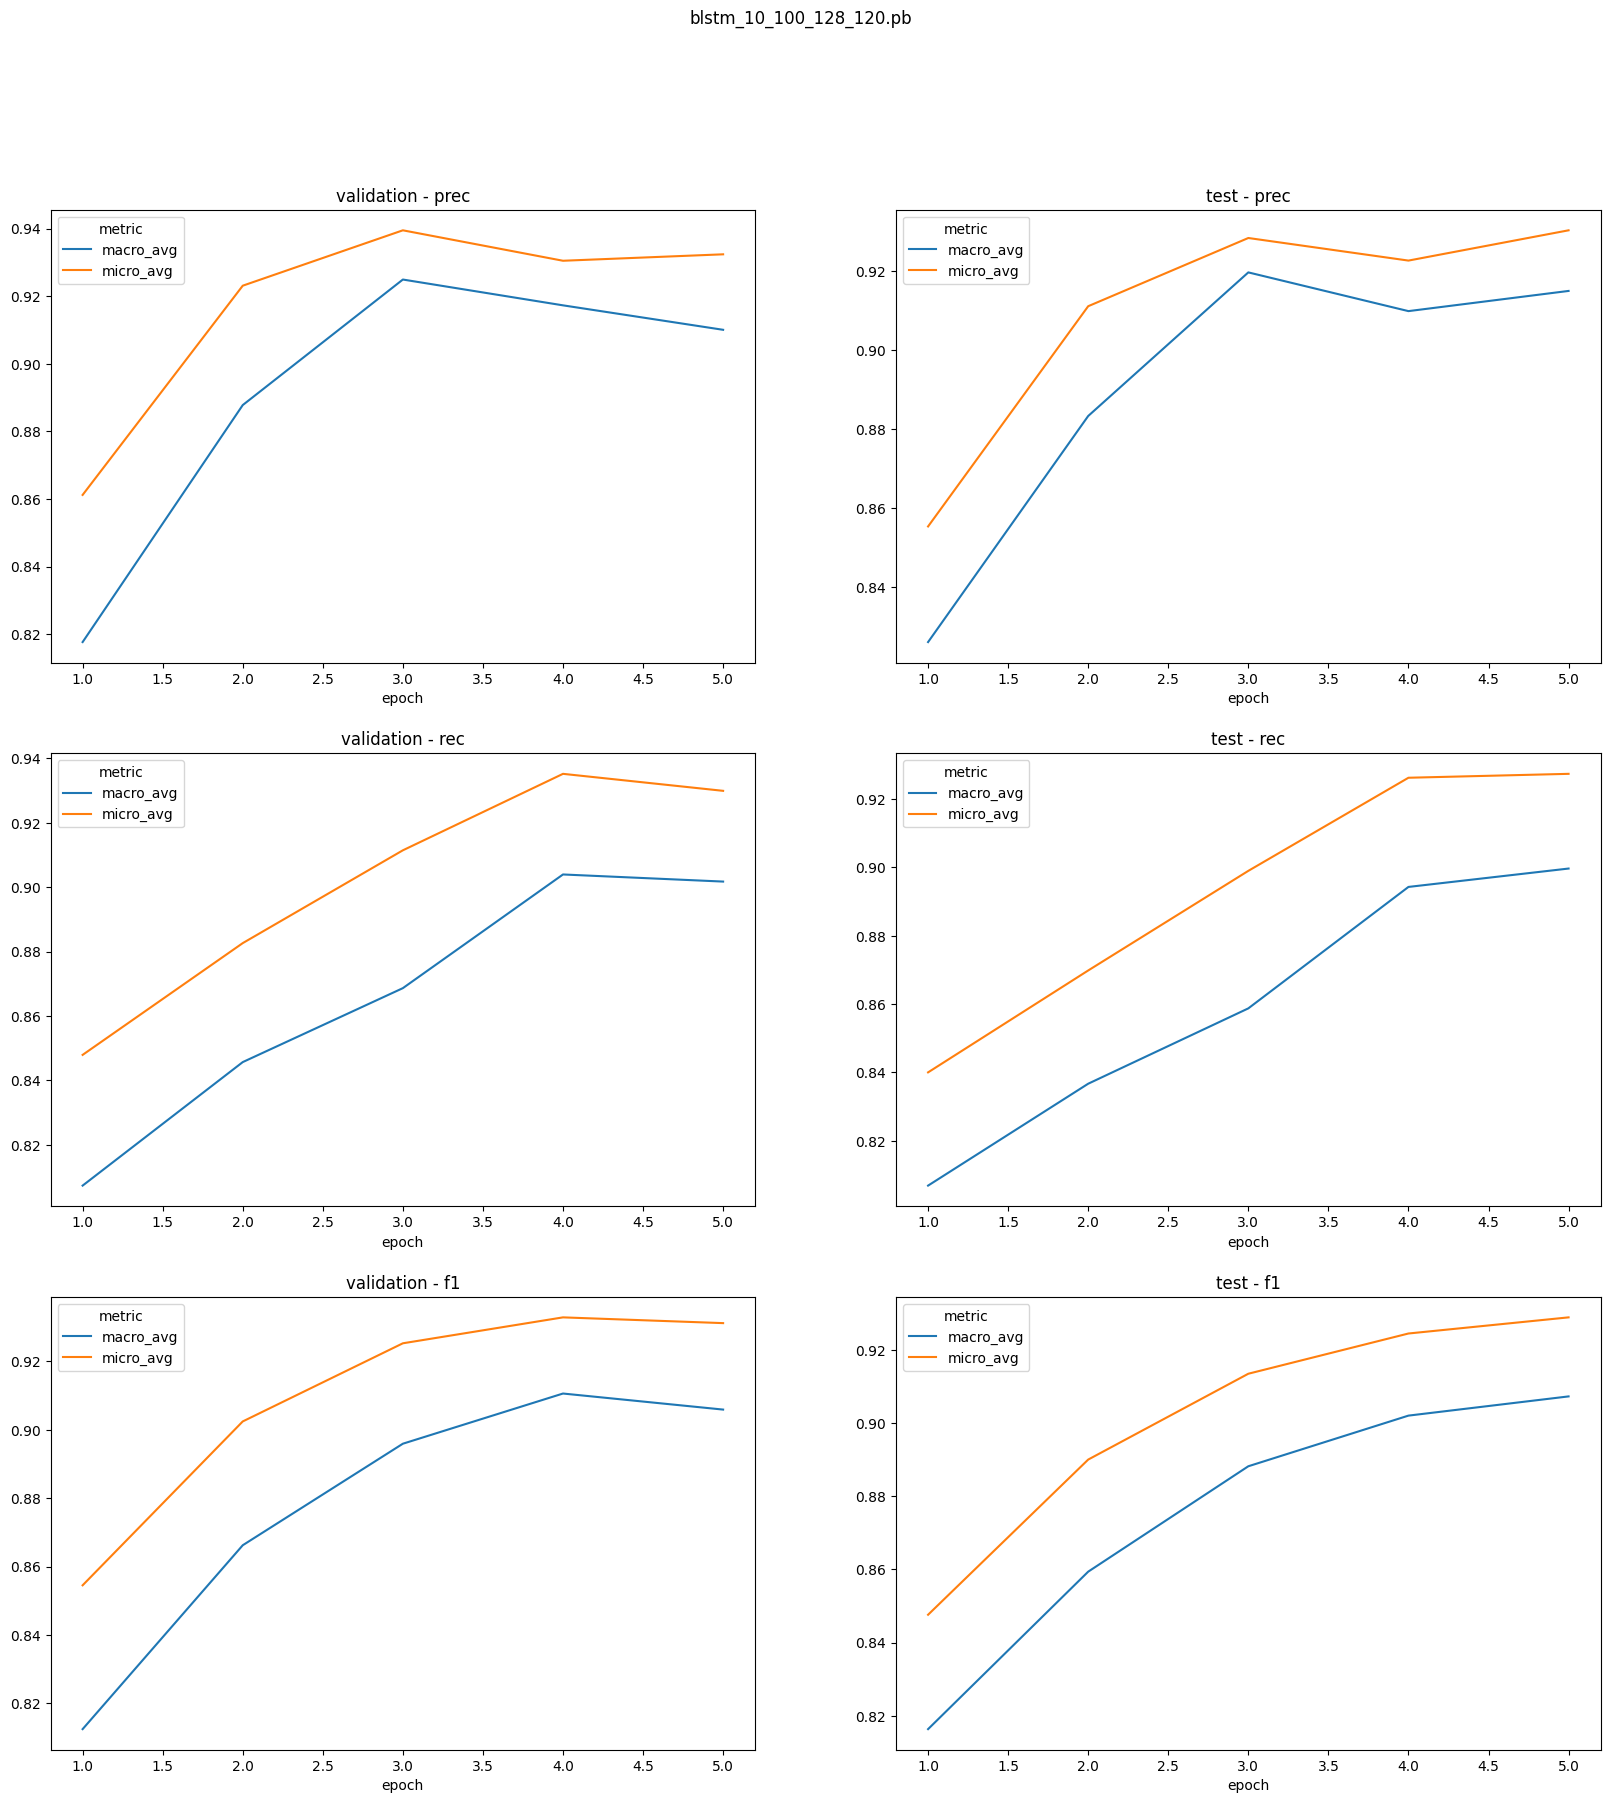

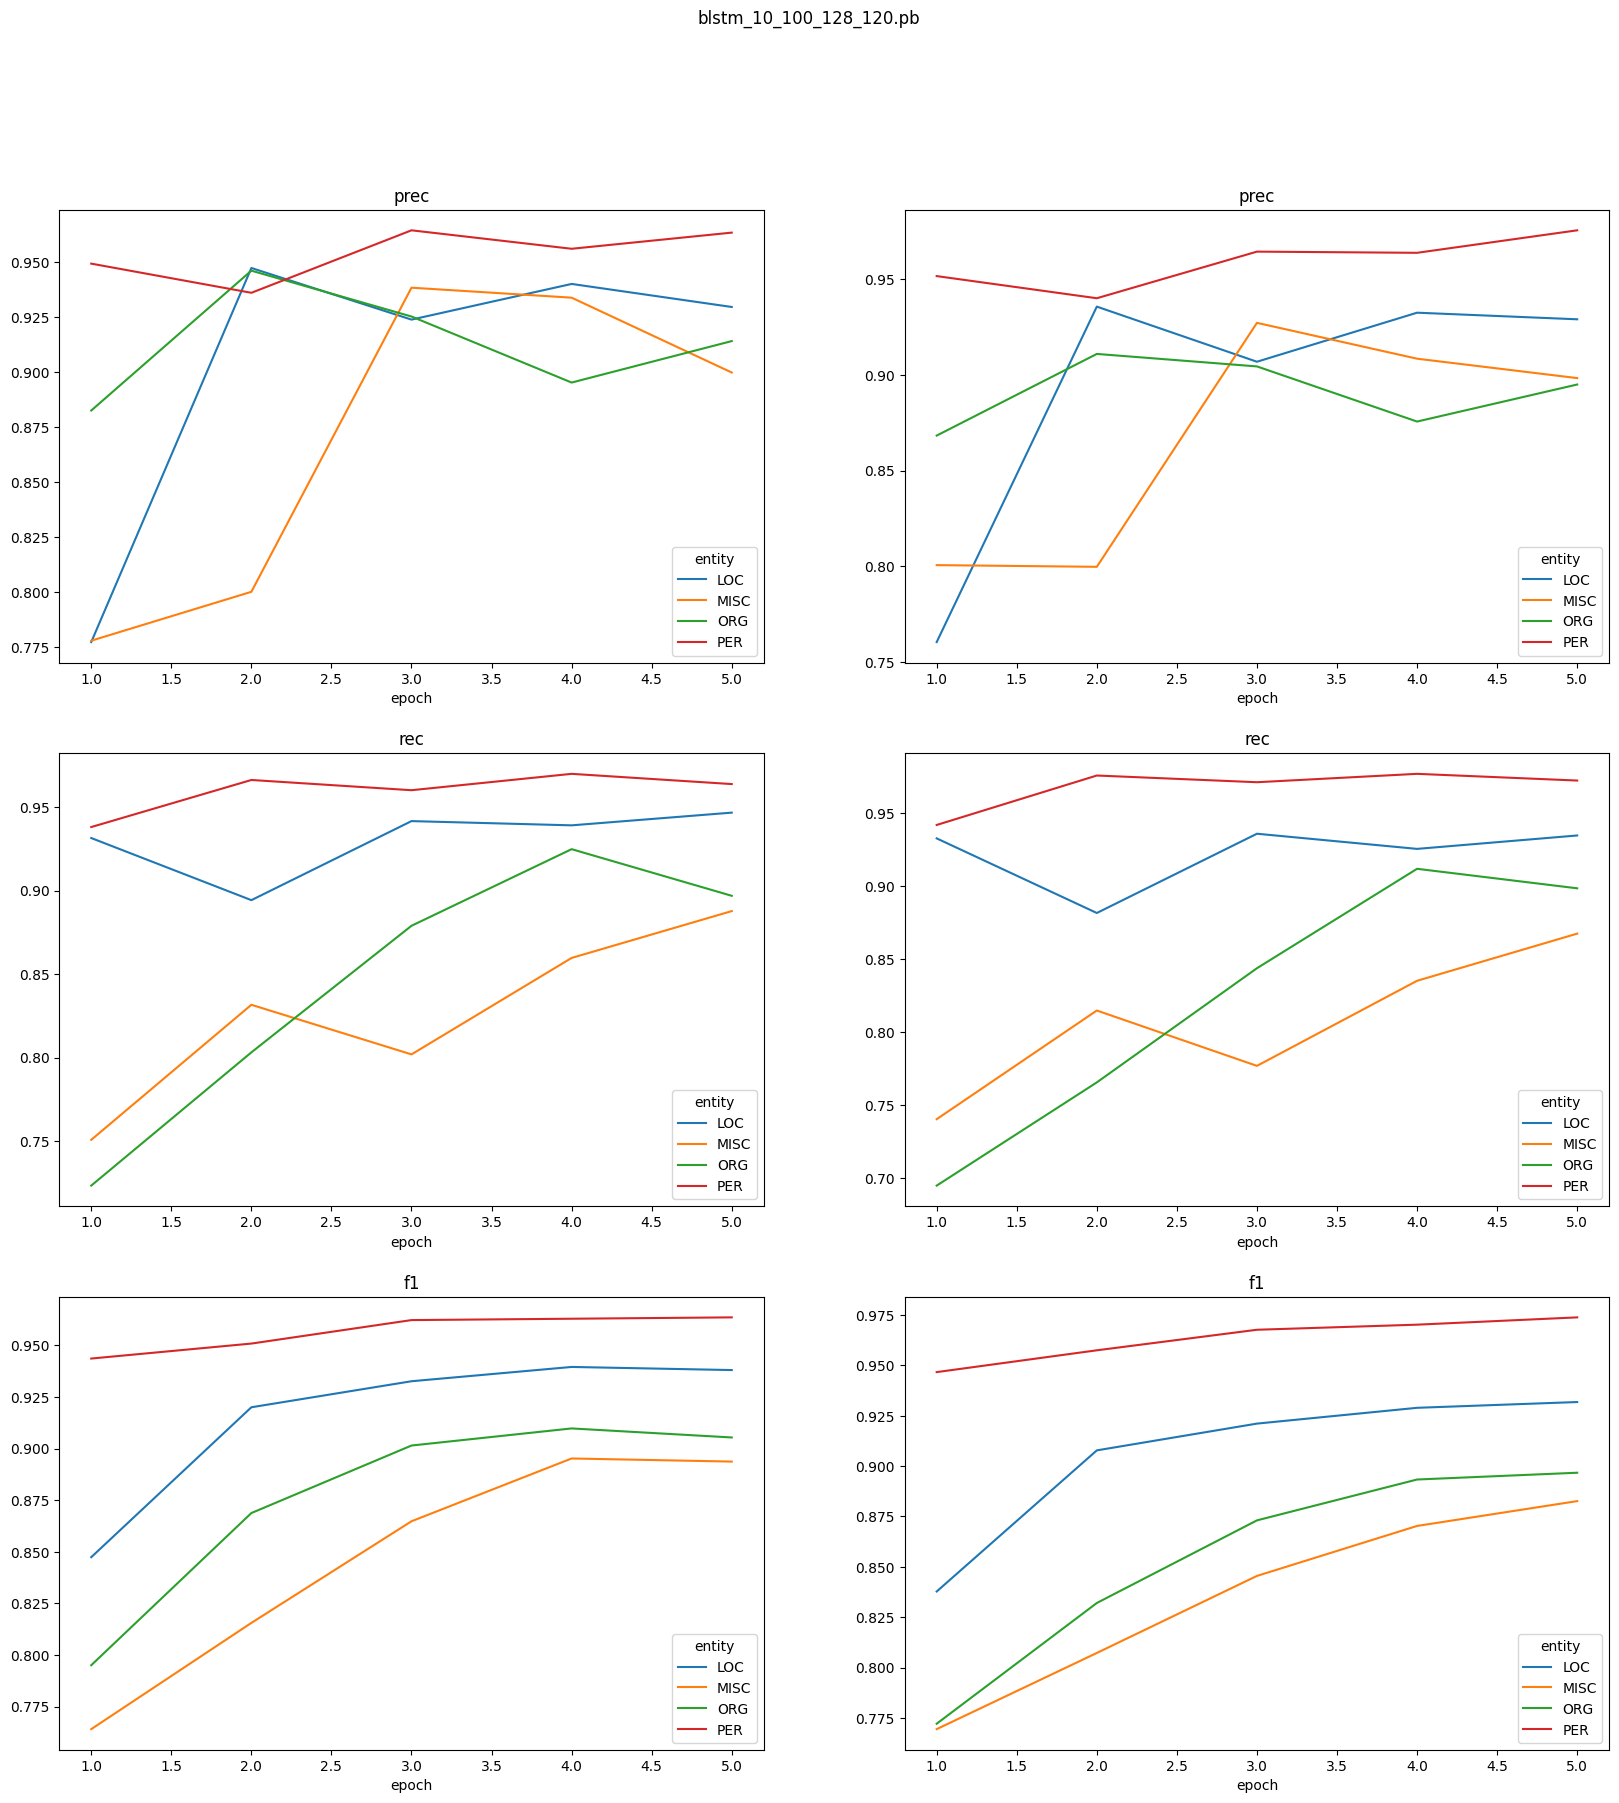

In [37]:
ner_log_parser.get_charts('/home/ubuntu/ner_logs_best/'+log_files[0])

**Plotting Loss**

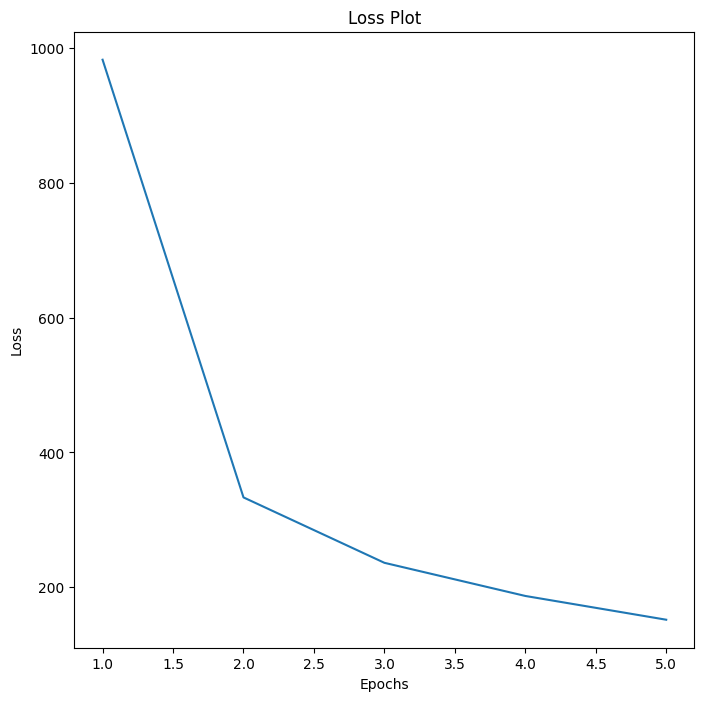

In [38]:
ner_log_parser.loss_plot('/home/ubuntu/ner_logs_best/'+log_files[0])

### Saving the trained model

In [39]:
ner_model.stages

[WORD_EMBEDDINGS_MODEL_48cffc8b9a76, NerDLModel_5cd8eb483c5a]

In [40]:
ner_model.stages[1].write().overwrite().save('NER_glove_e5_b32')

In [41]:
!ls -lt

total 9467840
drwxr-xr-x 4 ubuntu ubuntu       4096 Jan 16 16:28 NER_glove_e5_b32
-rw-r--r-- 1 ubuntu ubuntu       3826 Jan 16 16:28 ner_log_parser.py.1
-rw-r--r-- 1 ubuntu ubuntu    3523480 Jan 16 16:28 4.NERDL_Training.ipynb
drwxr-xr-x 2 ubuntu ubuntu       4096 Jan 16 16:25 ner_dl_test.parquet1
-rw-r--r-- 1 ubuntu ubuntu       7431 Jan 16 16:24 conll_eval.py.1
-rw-r--r-- 1 ubuntu ubuntu     827443 Jan 16 16:23 eng.testa.2
-rw-r--r-- 1 ubuntu ubuntu    3283420 Jan 16 16:23 eng.train.2
-rw-r--r-- 1 ubuntu ubuntu     936542 Jan 16 16:22 3.SparkNLP_Pretrained_Models.ipynb
-rw-r--r-- 1 ubuntu ubuntu         32 Jan 16 16:19 entities.txt
-rw-r--r-- 1 ubuntu ubuntu     342894 Jan 16 16:01 hs_err_pid22646.log
-rw-r--r-- 1 ubuntu ubuntu    3837253 Jan 16 15:06 2.Text_Preprocessing_with_SparkNLP_Annotators_Transformers.ipynb
-rw-r--r-- 1 ubuntu ubuntu        195 Jan 16 15:04 regex_rules.txt
-rw-r--r-- 1 ubuntu ubuntu         27 Jan 16 15:04 financial_entities.txt
-rw-r--r-- 1 ubuntu ubuntu    

## Prediction Pipeline

In [42]:
document = DocumentAssembler()\
        .setInputCol("text")\
        .setOutputCol("document")

sentence = SentenceDetector()\
        .setInputCols(['document'])\
        .setOutputCol('sentence')

token = Tokenizer()\
        .setInputCols(['sentence'])\
        .setOutputCol('token')

glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d')\
        .setInputCols(["document", "token"])\
        .setOutputCol("embeddings")
  
# load trained model
loaded_ner_model = NerDLModel.load("NER_glove_e5_b32")\
        .setInputCols(["sentence", "token", "embeddings"])\
        .setOutputCol("ner")

converter = NerConverter()\
        .setInputCols(["document", "token", "ner"])\
        .setOutputCol("ner_span")

ner_prediction_pipeline = Pipeline(stages = [
        document,
        sentence,
        token,
        glove_embeddings,
        loaded_ner_model,
        converter
])

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [43]:
empty_data = spark.createDataFrame([['']]).toDF("text")

prediction_model = ner_prediction_pipeline.fit(empty_data)

In [44]:
text = "Peter Parker is a nice guy and lives in New York."

sample_data = spark.createDataFrame([[text]]).toDF("text")

sample_data.show(truncate=False)

+-------------------------------------------------+
|text                                             |
+-------------------------------------------------+
|Peter Parker is a nice guy and lives in New York.|
+-------------------------------------------------+



In [45]:
preds = prediction_model.transform(sample_data)

preds.select(F.explode(F.arrays_zip(preds.ner_span.result,preds.ner_span.metadata)).alias("entities")) \
      .select(F.expr("entities['0']").alias("chunk"),
              F.expr("entities['1'].entity").alias("entity")).show(truncate=False)

+------------+------+
|chunk       |entity|
+------------+------+
|Peter Parker|PER   |
|New York    |LOC   |
+------------+------+



In [46]:
from sparknlp.base import LightPipeline

light_model = LightPipeline(prediction_model)

In [47]:
text = "Peter Parker is a nice guy and lives in New York."

result = light_model.annotate(text)

list(zip(result['token'], result['ner']))

[('Peter', 'B-PER'),
 ('Parker', 'I-PER'),
 ('is', 'O'),
 ('a', 'O'),
 ('nice', 'O'),
 ('guy', 'O'),
 ('and', 'O'),
 ('lives', 'O'),
 ('in', 'O'),
 ('New', 'B-LOC'),
 ('York', 'I-LOC'),
 ('.', 'O')]

In [48]:
import pandas as pd

result = light_model.fullAnnotate(text)

ner_df= pd.DataFrame([(int(x.metadata['sentence']), x.result, x.begin, x.end, y.result) for x,y in zip(result[0]["token"], result[0]["ner"])], 
                      columns=['sent_id','token','start','end','ner'])
ner_df

sent_id   token  start  end    ner
0         0   Peter      0    4  B-PER
1         0  Parker      6   11  I-PER
2         0      is     13   14      O
3         0       a     16   16      O
4         0    nice     18   21      O
5         0     guy     23   25      O
6         0     and     27   29      O
7         0   lives     31   35      O
8         0      in     37   38      O
9         0     New     40   42  B-LOC
10        0    York     44   47  I-LOC
11        0       .     48   48      O

### Highlight Entities

In [49]:
! pip install -q spark-nlp_display

In [50]:
from sparknlp.pretrained import PretrainedPipeline

pipeline = PretrainedPipeline('recognize_entities_dl', lang='en')

recognize_entities_dl download started this may take some time.
Approx size to download 160.1 MB
[ | ]recognize_entities_dl download started this may take some time.
Approximate size to download 160.1 MB
Download done! Loading the resource.
[OK!]


In [51]:
ann_text = pipeline.fullAnnotate('Peter Parker is a nice persn and lives in New York. Bruce Wayne is also a nice guy and lives in Gotham City.')[0]
ann_text.keys()

dict_keys(['entities', 'document', 'token', 'ner', 'embeddings', 'sentence'])

In [52]:
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()
print ('Standard Output')
visualiser.display(ann_text, label_col='entities', document_col='document')

# Change color of an entity label
visualiser.set_label_colors({'LOC':'#008080', 'PER':'#800080'})
visualiser.display(ann_text, label_col='entities')

# Set label filter
visualiser.display(ann_text, label_col='entities', document_col='document',
                   labels=['PER'])

print ('\nColor code for label: \n"LOC": {}\n"PER": {}' .format(visualiser.get_label_color('LOC'),visualiser.get_label_color('PER')) )

Standard Output



Color code for label: 
"LOC": #008080
"PER": #800080


# Creating Your Own CoNLL dataset

for a detailed overview of how to create a CoNLL file from any annotation, see here >> https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.3.prepare_CoNLL_from_annotations_for_NER.ipynb


In [53]:
import json
import os
from pyspark.ml import Pipeline
from sparknlp.base import *
from sparknlp.annotator import *
import sparknlp

spark = sparknlp.start()

def get_ann_pipeline ():
    
    document_assembler = DocumentAssembler() \
          .setInputCol("text")\
          .setOutputCol('document')

    sentencer = SentenceDetector()\
          .setInputCols(['document'])\
          .setOutputCol('sentence')

    tokenizer = Tokenizer() \
          .setInputCols(["sentence"]) \
          .setOutputCol("token")

    pos = PerceptronModel.pretrained() \
          .setInputCols(["sentence", "token"]) \
          .setOutputCol("pos")
    
    embeddings = WordEmbeddingsModel.pretrained()\
          .setInputCols(["sentence", "token"])\
          .setOutputCol("embeddings")

    ner_model = NerDLModel.pretrained() \
          .setInputCols(["sentence", "token", "embeddings"]) \
          .setOutputCol("ner")

    ner_converter = NerConverter()\
          .setInputCols(["sentence", "token", "ner"])\
          .setOutputCol("ner_chunk")

    ner_pipeline = Pipeline(
        stages = [
            document_assembler,
            sentencer,
            tokenizer,
            pos,
            embeddings,
            ner_model,
            ner_converter
        ])

    empty_data = spark.createDataFrame([[""]]).toDF("text")

    ner_pipelineFit = ner_pipeline.fit(empty_data)

    ner_lp_pipeline = LightPipeline(ner_pipelineFit)

    print ("Spark NLP NER lightpipeline is created")

    return ner_lp_pipeline


conll_pipeline = get_ann_pipeline ()



pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[ | ]pos_anc download started this may take some time.
Approximate size to download 3.9 MB
Download done! Loading the resource.


[ / ]

[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]
ner_dl download started this may take some time.
Approximate size to download 13.6 MB
[ | ]ner_dl download started this may take some time.
Approximate size to download 13.6 MB
Download done! Loading the resource.
[OK!]
Spark NLP NER lightpipeline is created


In [54]:
sentences = ["Peter Parker is a nice guy and lives in New York.",
"He is also helping people around the world."]

conll_lines=''

for sentence in sentences:

  parsed = conll_pipeline.annotate (sentence)

  for token, pos, ner in zip(parsed['token'],parsed['pos'],parsed['ner']):

      conll_lines += "{} {} {} {}\n".format(token, pos, pos, ner)

  conll_lines += '\n'


print(conll_lines)

Peter NNP NNP B-PER
Parker NNP NNP I-PER
is VBZ VBZ O
a DT DT O
nice JJ JJ O
guy NN NN O
and CC CC O
lives NNS NNS O
in IN IN O
New NNP NNP B-LOC
York NNP NNP I-LOC
. . . O

He PRP PRP O
is VBZ VBZ O
also RB RB O
helping VBG VBG O
people NNS NNS O
around IN IN O
the DT DT O
world NN NN O
. . . O




# NerDL Graph

Licensed users would use this module to create graphs for each DL model (`ner_dl`, `generic_classifier`, `assertion_dl`, `relation_extraction`) in Spark NLP but in open source, you need to run the other cell.

```
from sparknlp_jsl.training import tf_graph

tf_graph.build("ner_dl", build_params={"embeddings_dim": 200, "nchars": 80, "ntags": 12}, model_location="./", model_filename="auto")
```

In [55]:
# ! pip -q install tensorflow==1.15.0
# ! pip install --upgrade pip
# ! pip install gast==0.2.2

In [56]:
%%capture

!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/create_graph.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/dataset_encoder.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/ner_model.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/ner_model_saver.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/sentence_grouper.py

%tensorflow_version 1.15

import create_graph

ntags = 19 # number of labels
embeddings_dim = 100
nchars =100

create_graph.create_graph(ntags, embeddings_dim, nchars)

# then move the graph to grap folder stated in NerDLApproach